# Proyecto Final

## Santiago González Silot y Ahmed Brek Prieto

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/Colab Notebooks/ProyectoFinal/unclassified.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/Colab Notebooks/ProyectoFinal/unclassified.zip
replace /content/data/unclassified/IM-0001-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
# Importamos lo necesario
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import shutil
import PIL.Image
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, ReLU, Activation, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from tqdm import tqdm_notebook
from tqdm import tqdm

In [4]:

##############################
#    Funciones auxiliares    #
##############################

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.xlabel("Épocas")
  plt.ylabel("Loss Function")
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  # plt.ylim(0.6,1)
  plt.xlabel("Épocas")
  plt.ylabel("Accuracy")
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)N
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy

### Funciones para la lectura de datos

# Función auxiliar para crear las carpetas necesarias
def create_dir():
    try:
        os.makedirs('./data/train')
        os.makedirs('./data/test')
    except:
        pass


# Función auxiliar para eliminar las carpetas que genera la función anterior
def remove_dir():
    try:
        shutil.rmtree('./data/train')
        shutil.rmtree('./data/test')    
    except:
        pass

In [5]:
##############################################################################

# Algunas variables y constantes globales
# Creamos la semilla
seed = 0
random.seed(0)


# Leemos el archivo csv en un dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProyectoFinal/Chest_xray_Corona_Metadata.csv')
# df = pd.read_csv('./Chest_xray_Corona_Metadata.csv')

# Se sustituye el nombre de las etiquetas por 1's y 0's
replace_dict = {'Pnemonia':1,
                'Normal':0}

df['Label'] = df['Label'].replace(replace_dict)



# Separamos los conjuntos de train y test
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=df.Label)


# print(train_df['Label'].value_counts())
# print(test_df['Label'].value_counts())


# Rutas de carpetas de train y test
unclassified_data_path = 'data/unclassified'
train_data_path = 'data/train'
test_data_path = 'data/test'


# Borramos y creamos las carpetas necesarias
remove_dir()
create_dir()


# Separamos las imágenes de train y test en distintas carpetas
for image in train_df['X_ray_image_name']:
    image_train = os.path.join(unclassified_data_path, str(image))
    shutil.copy(image_train, train_data_path)

for image in test_df['X_ray_image_name']:
    image_test = os.path.join(unclassified_data_path, str(image))
    shutil.copy(image_test, test_data_path)


# Creamos un ImageDataGenerator para realizar data augmentation sobre una única clase
datagen_augmentation = ImageDataGenerator(
                                          rotation_range=0.2,
                                          width_shift_range=0.025,
                                          zoom_range=0.1,
                                          fill_mode='nearest')



def read_img(filename, size, path):
    img = tensorflow.keras.utils.load_img(os.path.join(path, filename), target_size=size)
    #convert image to array
    img = tensorflow.keras.utils.img_to_array(img) / 255
    return img





# Aumentamos sólo los datos de pacientes sanos para balancear los datos

normal_df = train_df[train_df['Label'] == 0]
normal_augmented = []

#create a function for augmentation
def augment(name):
    img = read_img(name, (255,255), train_data_path)
    i = 0
    for batch in tqdm(datagen_augmentation.flow(tensorflow.expand_dims(img, 0), batch_size=32)):
        normal_augmented.append(tensorflow.squeeze(batch).numpy())
        if i == 1:
            break
        i = i+1

# Aplicamos la función
# normal_augmented contendrá las imágenes generadas
normal_df['X_ray_image_name'].apply(augment)



# Extraer las imágenes de los conjuntos de datos de train y test y convertirlos en arrays
train_arrays = [] 
train_df['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (255,255), train_data_path)))
test_arrays = []
test_df['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (255,255), test_data_path)))


# Concatenamos las etiquetas de los datos de train y las de las imágenes generadas con data augmentation
y_train = np.concatenate((np.int64(train_df['Label'].values), np.zeros(len(normal_augmented), dtype=np.int64)))

y_test = test_df['Label'].values

train_array_aug = np.concatenate((np.array(train_arrays), np.array(normal_augmented)))


100%|██████████| 1/1 [00:00<00:00, 41.42it/s]


In [6]:
# Lo pasamos a array
test_arrays = np.array(test_arrays)

In [7]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
no_epochs = 15
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)




#Creating an EffNet model
model_resnet = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)



train_datagen = ImageDataGenerator(validation_split=0.1,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True)
# Añadir normalizacion de datos
test_datagen = ImageDataGenerator()

train_datagen.fit(train_array_aug)
train_datagen.standardize(test_arrays)


train_generator = train_datagen.flow(train_array_aug, y_train,
                               batch_size=64,
                               shuffle=True,
                               subset='training')

validation_generator = train_datagen.flow(train_array_aug, y_train,
                               batch_size=64,
                               shuffle=True,
                               subset='validation')

test_generator = test_datagen.flow(test_arrays, y_test,
                                   shuffle=False)



pretrained_model = model_resnet
pretrained_model.trainable=False


model=Sequential()
model.add(pretrained_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


es_callback = EarlyStopping(monitor='val_loss', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)


# Añadir early stopping callbacks = [es_callback]
history = model.fit(train_generator,
                    epochs = no_epochs,
                    validation_data = validation_generator,
                    callbacks = [es_callback],
                    verbose=verbosity)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5

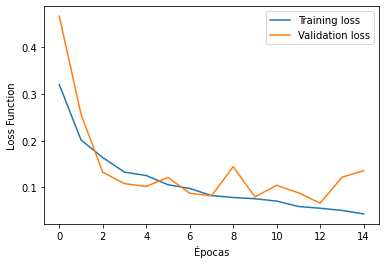

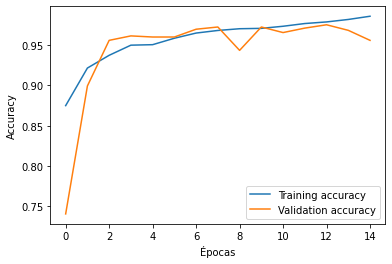

In [8]:
mostrarEvolucion(history)

In [9]:
# Tomamos ls predicciones
y_pred = model.predict(test_generator)
y_pred = np.rint(y_pred)

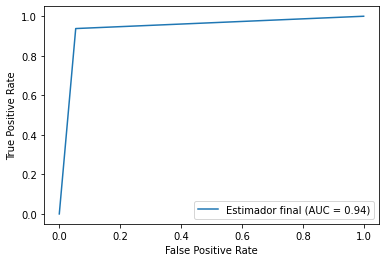

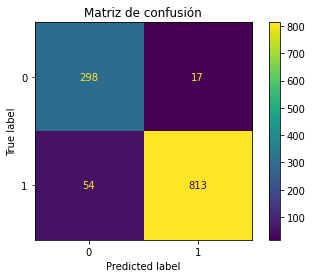

In [10]:
# Para pintar la curva ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Estimador final')
display.plot()
plt.show()

# Para pintar la matriz de confusión
m = confusion_matrix(y_test, y_pred)
m = ConfusionMatrixDisplay(confusion_matrix=m)
m.plot()
plt.title("Matriz de confusión")
plt.show()

In [11]:
# Obtenemos el Loss y el Accuracy para el conjunto de Test
prediccion = model.evaluate(test_generator)
print(f" Test Loss: {prediccion[0]}")
print(f" Test Accuracy: {prediccion[1]}")

37/37 [==============================] - 3s 78ms/step - loss: 0.2654 - accuracy: 0.9399
 Test Loss: 0.2654021084308624
 Test Accuracy: 0.9399323463439941


In [12]:
m = tensorflow.keras.metrics.BinaryAccuracy()
m.update_state(y_test, y_pred)
print("Binary Accuracy: ", m.result().numpy())

m = tensorflow.keras.metrics.Accuracy()
m.update_state(y_test, y_pred)
print("Accuracy: ", m.result().numpy())

Binary Accuracy:  0.93993235
Accuracy:  0.93993235
